In [175]:
import pylab as plt
import xarray as xr
from pathlib import Path
import geopandas as gp
from matplotlib import cm, colors
from matplotlib.colors import LightSource

import rioxarray as rxr
import geopandas as gp
import time
import pandas as pd
import cartopy.crs as ccrs
from dask.distributed import Client, LocalCluster

from pism_ragis.processing import preprocess_nc
from pism_ragis.observations import load_imbie, load_mouginot, load_mankoff
from pypism.utils import blend_multiply, qgis2cmap

In [958]:
import toml

In [108]:
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0

In [961]:
toml.load("../analysis/2024_03_test.toml")

{'project': 'RAGIS vs GrIMP',
 'ensemble': {'proj_dir': '2024_02_ragis',
  'ensemble_id': 'RAGIS',
  'scalar_dir': 'scalar',
  'resolution': 900,
  'spatial_dir': 'spatial'},
 'ensmble': {'proj_dir': '2024_02_grimp',
  'ensemble_id': 'GrIMP',
  'scalar_dir': 'scalar',
  'resolution': 900,
  'spatial_dir': 'spatial'}}

In [930]:
data_dir = Path("/mnt/storstrommen/ragis/data/pism")
obs_dir = Path("/mnt/storstrommen/data/")
assert data_dir.exists()

results_dir = "2024_03_analysis"
o_dir = data_dir / results_dir
o_dir.mkdir(exist_ok=True)
fig_dir = o_dir / "figures"
fig_dir.mkdir(exist_ok=True)

In [110]:
exps = []
exp = {"proj_dir": "2024_02_grimp",
       "ensemble_id": "GrIMP",
       "scalar_dir": "scalar",
       "resolution": 900,
       "spatial_dir": "spatial"}
exps.append(exp)
exp = {"proj_dir": "2024_02_ragis",
       "ensemble_id": "RAGIS",
       "scalar_dir": "scalar",
       "resolution": 900,
       "spatial_dir": "spatial"}
exps.append(exp)

In [111]:
spatial_dss = []
scalar_dss = []
for exp in exps:

    spatial_url = data_dir / Path(exp["proj_dir"]) / Path(exp["spatial_dir"])
    spatial_urls = spatial_url.glob(f"""ex_gris_g{exp["resolution"]}m*.nc""")
    spatial_ds = xr.open_mfdataset(spatial_urls, preprocess=preprocess_nc, concat_dim="exp_id", combine="nested", parallel=True)
    spatial_ds.expand_dims("ensemble_id")
    spatial_ds["ensemble_id"] = exp["ensemble_id"]
    spatial_dss.append(spatial_ds)
    
    scalar_url = data_dir / Path(exp["proj_dir"]) / Path(exp["scalar_dir"])
    scalar_urls = scalar_url.glob(f"""ts_gris_g{exp["resolution"]}m*.nc""")
    scalar_ds = xr.open_mfdataset(scalar_urls, preprocess=preprocess_nc, concat_dim="exp_id", combine="nested", parallel=True)
    scalar_ds.expand_dims("ensemble_id")
    scalar_ds["ensemble_id"] = exp["ensemble_id"]
    scalar_dss.append(scalar_ds)

In [112]:
spatial_ds = xr.concat(spatial_dss, dim="ensemble_id")
scalar_ds = xr.concat(scalar_dss, dim="ensemble_id")


In [113]:
mou = load_mouginot(url=Path("/mnt/storstrommen/ragis/data/mouginot/pnas.1904242116.sd02.xlsx"), norm_year=1980)
mou_gis = mou[mou["Basin"] == "GIS"]

In [114]:
basins = gp.read_file("../data/basins/Greenland_Basins_PS_v1.4.2.shp").to_crs("EPSG:3413")

In [115]:
spatial_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
spatial_ds.rio.write_crs("epsg:3413", inplace=True)

<xarray.Dataset>
Dimensions:                                         (time: 480, x: 1760,
                                                     y: 3040, exp_id: 3,
                                                     ensemble_id: 2, nv: 2)
Coordinates:
  * time                                            (time) datetime64[ns] 198...
  * x                                               (x) float64 -6.782e+05 .....
  * y                                               (y) float64 -3.371e+06 .....
  * exp_id                                          (exp_id) <U19 'BAYES-MEDI...
    mapping                                         int64 0
  * ensemble_id                                     (ensemble_id) <U5 'GrIMP'...
Dimensions without coordinates: nv
Data variables: (12/24)
    time_bounds                                     (ensemble_id, exp_id, time, nv) datetime64[ns] dask.array<chunksize=(1, 1, 1, 2), meta=np.ndarray>
    pism_config                                     (ensemble_id, exp_id) int8 ...
    run_stats                                       (ensemble_id, exp_id) float64 ...
    timestamp                                       (ensemble_id, exp_id, time) timedelta64[ns] dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    dHdt                                            (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    flux_divergence                                 (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    ...                                              ...
    tendency_of_ice_mass_due_to_frontal_melt        (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    tendency_of_ice_mass_due_to_surface_mass_flux   (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    thk                                             (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    usurf                                           (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    velsurf_mag                                     (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    vonmises_calving_rate                           (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    command:       /home1/aaschwan/local/pism-dev/bin/pismr -profile /nobacku...
    history:      aaschwan@r445i4n7 2024-03-01 19:25:16 PST: PISM (2024-02-15...
    institution:  University of Alaska Fairbanks
    proj:         epsg:3413
    source:       PISM (2024-02-15-da843103f committed by Constantine Khrulev...

In [116]:
client = Client(n_workers=2, threads_per_worker=1, memory_limit='64GB')

In [117]:

start = time.process_time()

with client:
    domain_mass = spatial_ds["ice_mass"].sum(dim=["x", "y"]).compute()
    basin_mass = spatial_ds["ice_mass"].rio.clip(basins.geometry).sum(dim=["x", "y"]).compute()
    scalar_mass = scalar_ds["ice_mass"].compute()
    scalar_limnsw = scalar_ds["limnsw"].compute()
    time_elapsed = time.process_time() - start
    print(f"Time elapsed {time_elapsed:.0f}s")


/home/andy/miniconda3/envs/pism-ragis/lib/python3.11/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Time elapsed 209s


In [118]:
domain_mass_scaled = (domain_mass - domain_mass.isel(time=0)) / 1e12
basin_mass_scaled = (basin_mass - basin_mass.isel(time=0)) / 1e12
scalar_mass_scaled = (scalar_mass - scalar_mass.isel(time=0)) / 1e12
scalar_limnsw_scaled = (scalar_limnsw - scalar_limnsw.isel(time=0)) / 1e12

domain_mass_sle = domain_mass_scaled * gt2cmsle
basin_mass_sle = basin_mass_scaled * gt2cmsle
scalar_mass_sle = scalar_mass_scaled * gt2cmsle
scalar_limnsw_sle = scalar_limnsw_scaled * gt2cmsle

## Compare RAGIS and GrIMP

(-3000.0, 500.0)

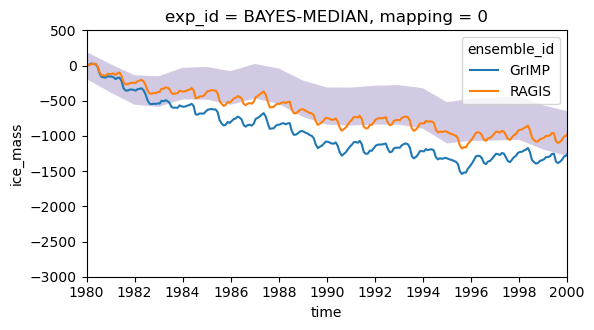

In [119]:
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#sim_colors = ["#882255", "#AA4499", "#CC6677", "#DDCC77", "#88CCEE", "#44AA99", "#117733", "#332288"]
imbie_color = "k"
imbie_color = "#238b45"
mou_color = "#6a51a3"

obs = mou_gis
obs_color = mou_color

sigma = 1
mass_varname = "Cumulative ice sheet mass change (Gt)"
mass_uncertainty_varname = "Cumulative ice sheet mass change uncertainty (Gt)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

fig = plt.figure(figsize=(6.2, 3.2))
ax = fig.add_subplot(111)
basin_mass_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", hue="ensemble_id", ax=ax, add_legend=True)
#domain_mass_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", hue="ensemble_id", ax=ax, label="domain")
#scalar_limnsw_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", hue="ensemble_id", ax=ax, label="limnsw")
#scalar_mass_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax, hue="ensemble_id", label="scalar_mass")
obs_ci = ax.fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30, label="1-$\sigma$")
#ax.legend()
#scalar_mass.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
ax.set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
ax.set_ylim(-3000, 500)

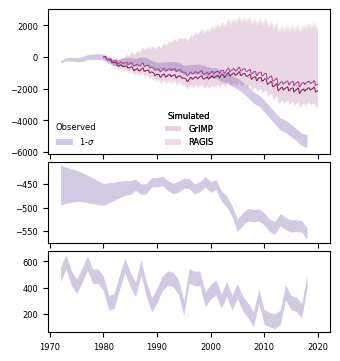

In [940]:
from cycler import cycler
    
colorlist = ['c', 'm', 'y', 'k']
    
#cmap = mpl.colors.ListedColormap(colorlist)
    
#custom_cycler = cycler(color=cmap.colors) #or simply color=colorlist
#ax.set_prop_cycle(custom_cycler)

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
sim_colors = ["#882255", "#AA4499", "#CC6677", "#DDCC77", "#88CCEE", "#44AA99", "#117733", "#332288"]
imbie_color = "k"
imbie_color = "#238b45"
mou_color = "#6a51a3"

obs = mou_gis
obs_color = mou_color

sigma = 1
sigma_smb = 1
sigma_discharge = 1
obs_alpha = 0.3
mass_varname = "Cumulative ice sheet mass change (Gt)"
mass_uncertainty_varname = "Cumulative ice sheet mass change uncertainty (Gt)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(3.6, 3.8), height_ratios=[16, 9, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)

sim_cis = []
for k, (exp_id, da) in enumerate(basin_mass_scaled.groupby("ensemble_id")):
    sim_ci = axs[0].fill_between(da.time, da.quantile(0.16, dim="exp_id"), da.quantile(0.84, dim="exp_id"), 
                        alpha=0.10, color=sim_colors[k], lw=0, label=exp_id)
    axs[0].plot(da.time, da.quantile(0.50, dim="exp_id"), lw=0.75, color=sim_colors[k])
    sim_cis.append(sim_ci)

#scalar_limnsw_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", hue="ensemble_id", ax=ax, label="limnsw")
#scalar_mass_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax, hue="ensemble_id", label="scalar_mass")
obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label="1-$\sigma$")

axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma_smb * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma_smb * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

legend_obs = axs[0].legend(handles=[obs_ci], loc="lower left",
                               title="Observed")
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
legend_sim = axs[0].legend(handles=sim_cis, loc="lower center",
                               title="Simulated")
legend_sim.get_frame().set_linewidth(0.0)
legend_sim.get_frame().set_alpha(0.0)

axs[0].add_artist(legend_obs)
axs[0].add_artist(legend_sim)
#scalar_mass.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
#axs[-1].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
#axs[-1].set_ylim(-3000, 2000)
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.png", dpi=600)

(3652.0, 10957.0)

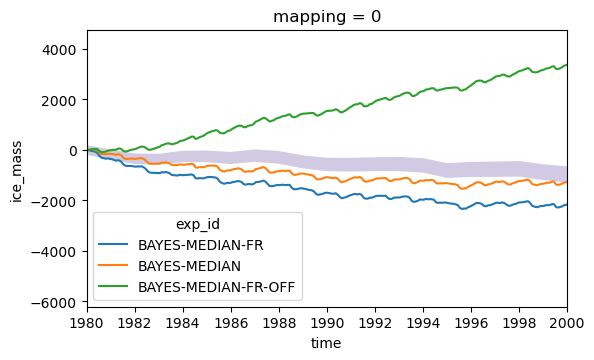

In [41]:
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#sim_colors = ["#882255", "#AA4499", "#CC6677", "#DDCC77", "#88CCEE", "#44AA99", "#117733", "#332288"]
imbie_color = "k"
imbie_color = "#238b45"
mou_color = "#6a51a3"

obs = mou_gis
obs_color = mou_color

sigma = 1
mass_varname = "Cumulative ice sheet mass change (Gt)"
mass_uncertainty_varname = "Cumulative ice sheet mass change uncertainty (Gt)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

fig = plt.figure(figsize=(6.2, 3.6))
ax = fig.add_subplot(111)
basin_mass_scaled.plot.line(x="time", hue="exp_id", ax=ax, add_legend=True)
obs_ci = ax.fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30, label="1-$\sigma$")


#ax.legend()
#scalar_mass.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
ax.set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
#ax.set_ylim(-1.5, 0.5)

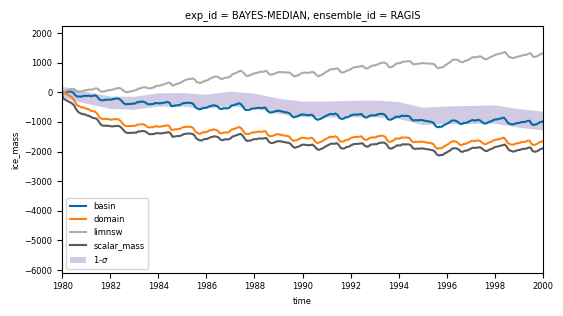

In [955]:
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#sim_colors = ["#882255", "#AA4499", "#CC6677", "#DDCC77", "#88CCEE", "#44AA99", "#117733", "#332288"]
imbie_color = "k"
imbie_color = "#238b45"
mou_color = "#6a51a3"

obs = mou_gis
obs_color = mou_color

sigma = 1
mass_varname = "Cumulative ice sheet mass change (Gt)"
mass_uncertainty_varname = "Cumulative ice sheet mass change uncertainty (Gt)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

fig = plt.figure(figsize=(6.2, 3.2))
ax = fig.add_subplot(111)
basin_mass_scaled.sel(exp_id="BAYES-MEDIAN", ensemble_id="RAGIS").plot.line(x="time", ax=ax, label="basin")
domain_mass_scaled.sel(exp_id="BAYES-MEDIAN", ensemble_id="RAGIS").plot.line(x="time", ax=ax, label="domain")
scalar_limnsw_scaled.sel(exp_id="BAYES-MEDIAN", ensemble_id="RAGIS").plot.line(x="time", ax=ax, label="limnsw")
scalar_mass_scaled.sel(exp_id="BAYES-MEDIAN", ensemble_id="RAGIS").plot.line(x="time", ax=ax, label="scalar_mass")
obs_ci = ax.fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30, label="1-$\sigma$")
ax.legend()
#scalar_mass.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
ax.set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig("mass_ragis.pdf")
#ax.set_ylim(-1.5, 0.5)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
basin_sle.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
basin_mass_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
#scalar_mass.plot.line(x="time", hue="exp_id", ax=ax)

In [ ]:
basin_sle.plot.line(x="time", hue="exp_id")
basin_mass_scaled.plot.line(x="time", hue="exp_id")

In [ ]:
domain_sle.plot.line(x="time", hue="exp_id")

In [162]:
from typing import Union, List
import numpy as np

In [946]:
qgis_colormap = obs_dir / Path("colormaps/speed-colorblind.txt")
cmap = qgis2cmap(qgis_colormap, name="speeds")

In [430]:
vel_url = obs_dir / Path("its-live/GRE_G0240_1985.nc")
vel_ds = xr.open_dataset(vel_url)
#vel_ds.coords["y"] = vel_ds.coords["y"][::-1]

In [431]:
bm_url = obs_dir / Path("MCDataset/BedMachineGreenland-v5.nc")
bm_ds = xr.open_dataset(bm_url)
#bm_ds.coords["y"] = bm_ds.coords["y"][::-1]

In [432]:
bm_ds.y

<xarray.DataArray 'y' (y: 18346)>
array([ -632675,  -632825,  -632975, ..., -3384125, -3384275, -3384425],
      dtype=int32)
Coordinates:
  * y        (y) int32 -632675 -632825 -632975 ... -3384125 -3384275 -3384425
Attributes:
    long_name:      Cartesian y-coordinate
    standard_name:  projection_y_coordinate
    units:          meter

In [832]:
def plot_glacier(
    surface: xr.DataArray,
    overlay: xr.DataArray,
    result_dir: Union[str, Path],
    extent: Union[None, List[float], np.ndarray] = None,
    origin: str = "lower",
    cmap="viridis",
    vmin: float = 10,
    vmax: float = 1500,
    label: str = "Speed (m/yr)",
    ticks: Union[List[float], np.ndarray] = [10, 100, 250, 500, 750, 1500],
):

    if (origin == "upper") and extent:
        extent["y"] = slice(extent["y"].start, extent["y"].stop, -1)
    else:
       extent["y"] = slice(extent["y"].start, extent["y"].stop, 1)
 
    def get_extent(ds: xr.DataArray, origin="lower"):
        if origin.lower() == "lower":
            return [ds["x"].values[0], ds["x"].values[-1], ds["y"].values[0], ds["y"].values[-1]]
        else:
            return [ds["x"].values[0], ds["x"].values[-1], ds["y"].values[-1], ds["y"].values[0]]
    
    crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
    # Shade from the northwest, with the sun 45 degrees from horizontal
    light_source = LightSource(azdeg=315, altdeg=45)
    if extent:
        glacier_overlay = overlay.sel(**extent)
    else:
        glacier_overlay = overlay
    glacier_surface = surface.interp_like(glacier_overlay)

    fig_extent = get_extent(glacier_overlay, origin=origin)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    v = mapper.to_rgba(glacier_overlay.to_numpy())
    z = glacier_surface.to_numpy()
    fig = plt.figure(figsize=(6.2, 6.2))
    ax = fig.add_subplot(111, projection=crs)
    rgb = light_source.shade_rgb(v, elevation=z, vert_exag=0.01, blend_mode=blend_multiply)
    # Use a proxy artist for the colorbar...
    im = ax.imshow(v, cmap=cmap, norm=norm)
    im.remove()
    ax.imshow(rgb, extent=fig_extent, origin=origin, transform=crs)

    ax.gridlines(
        draw_labels={"top": "x", "right": "y"},
        dms=True,
        xlocs=np.arange(-50, 0, 5),
        ylocs=np.arange(50, 88, 5),
        x_inline=False,
        y_inline=False,
        rotate_labels=20,
        ls="dotted",
        color="k",
    )

    ax.set_extent(fig_extent, crs=crs)
    fig.colorbar(
        im, ax=ax, shrink=0.5, pad=0.025, label=label, extend="both", orientation="horizontal", location="bottom"
    )
    fig.savefig(result_dir / Path("speed.pdf"))
    plt.close()
    del fig


In [956]:
jak_extent = {"x": slice(-220_000, -100_000), "y": slice(-2325_000, -2225_000, -1)}

In [842]:
result_dir = Path("figures")
result_dir.mkdir(parents=True, exist_ok=True)
plot_glacier(bm_ds["surface"], vel_ds["v"], result_dir, cmap=cmap, extent=jak_extent, origin="upper")

In [843]:
s_1985 = spatial_ds.sel(time=slice("1985-01-01", "1986-01-01"), ensemble_id="RAGIS", exp_id="BAYES-MEDIAN").mean(dim="time")

In [844]:
plot_glacier(s_1985["usurf"], s_1985["velsurf_mag"], result_dir, cmap=cmap, extent=jak_extent, origin="lower")

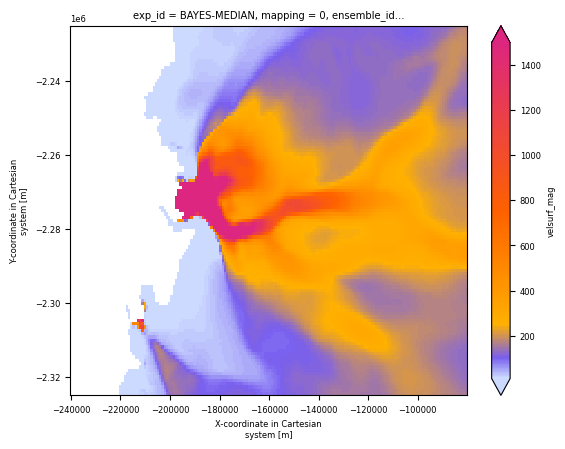

In [841]:
s_1985.sel(**jak_extent)["velsurf_mag"].plot(cmap=cmap, vmin=10, vmax=1500)

In [944]:
def plot_obs_sim_glacier(
    obs_surface: xr.DataArray,
    obs_overlay: xr.DataArray,
    sim_surface: xr.DataArray,
    sim_overlay: xr.DataArray,

    result_dir: Union[str, Path] = Path("."),
    extent: Union[None, List[float], np.ndarray] = None,
    cmap="viridis",
    vmin: float = 10,
    vmax: float = 1500,
    label: str = "Speed (m/yr)",
    ticks: Union[List[float], np.ndarray] = [10, 100, 250, 500, 750, 1500],
):

 
    def get_extent(ds: xr.DataArray, origin="lower"):
        if origin.lower() == "lower":
            return [ds["x"].values[0], ds["x"].values[-1], ds["y"].values[0], ds["y"].values[-1]]
        else:
            return [ds["x"].values[0], ds["x"].values[-1], ds["y"].values[-1], ds["y"].values[0]]
    
    crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
    # Shade from the northwest, with the sun 45 degrees from horizontal
    light_source = LightSource(azdeg=315, altdeg=45)

    def prep_data(surface: xr.DataArray,
                  overlay: xr.DataArray,
                  extent=extent,
                  origin="lower"
                 ):
        
        if (origin == "upper") and extent:
            extent["y"] = slice(extent["y"].start, extent["y"].stop, -1)
        else:
           extent["y"] = slice(extent["y"].start, extent["y"].stop, 1)
        if extent:
            overlay = overlay.sel(**extent)
        surface = surface.interp_like(overlay)

        fig_extent = get_extent(overlay, origin=origin)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

        v = mapper.to_rgba(overlay.to_numpy())
        z = surface.to_numpy()
        rgb = light_source.shade_rgb(v, elevation=z, vert_exag=0.01, blend_mode=blend_multiply)
        return z, v, rgb, norm, fig_extent


    
    fig, axs = plt.subplots(3, 1, figsize=(6.2, 6.6), sharey=True, subplot_kw={"projection": crs})

    handles = []
    # Observations
    origin="upper"
    z, v, rgb, norm, fig_extent = prep_data(obs_surface, obs_overlay, origin=origin)
    im = axs[0].imshow(v, cmap=cmap, norm=norm)
    im.remove()
    obs_h = axs[0].imshow(rgb, extent=fig_extent, origin=origin, transform=crs, label="ITS_LIVE")
    handles.append(obs_h)
    for ax in axs:
        ax.gridlines(
            draw_labels={"top": "x", "right": "y"},
            dms=True,
            xlocs=np.arange(-50, 0, 2),
            ylocs=np.arange(50, 88, 2),
            x_inline=False,
            y_inline=False,
            rotate_labels=20,
            ls="dotted",
            color="k",
        )

    axs[0].set_extent(fig_extent, crs=crs)

    origin = "lower"
    for k, (surface, overlay) in enumerate(zip(sim_surface.groupby("ensemble_id"), sim_overlay.groupby("ensemble_id"))):
        z, v, rgb, norm, fig_extent = prep_data(surface[1], overlay[1], origin=origin)
        sim_h = axs[k+1].imshow(rgb, extent=fig_extent, origin=origin, transform=crs, label = surface[0])
        handles.append(sim_h)
    #fig.legend(handles)
    fig.colorbar(
        im, ax=ax, shrink=0.5, pad=0.025, label=label, extend="both", orientation="horizontal", location="bottom"
    )
    fig.savefig(result_dir / Path("speed.pdf"))
    plt.close()
    del fig

In [957]:
s_1985 = spatial_ds.sel(time=slice("1985-01-01", "1986-01-01"), exp_id="BAYES-MEDIAN").mean(dim="time")
plot_obs_sim_glacier(obs_surface=bm_ds["surface"], obs_overlay=vel_ds["v"], sim_surface=s_1985["usurf"], sim_overlay=s_1985["velsurf_mag"], result_dir=result_dir, cmap=cmap, extent=jak_extent)

In [890]:
for k, (surface, overlay) in enumerate(zip(s_1985["usurf"].groupby("ensemble_id"), s_1985["velsurf_mag"].groupby("ensemble_id"))):
    print(surface, overlay)

('GrIMP', <xarray.DataArray 'usurf' (y: 3040, x: 1760)>
dask.array<getitem, shape=(3040, 1760), dtype=float32, chunksize=(1014, 587), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -6.782e+05 -6.773e+05 ... 9.04e+05 9.049e+05
  * y            (y) float64 -3.371e+06 -3.37e+06 ... -6.37e+05 -6.36e+05
    exp_id       <U19 'BAYES-MEDIAN'
    mapping      int64 0
    ensemble_id  <U5 'GrIMP') ('GrIMP', <xarray.DataArray 'velsurf_mag' (y: 3040, x: 1760)>
dask.array<getitem, shape=(3040, 1760), dtype=float32, chunksize=(1014, 587), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -6.782e+05 -6.773e+05 ... 9.04e+05 9.049e+05
  * y            (y) float64 -3.371e+06 -3.37e+06 ... -6.37e+05 -6.36e+05
    exp_id       <U19 'BAYES-MEDIAN'
    mapping      int64 0
    ensemble_id  <U5 'GrIMP')
('RAGIS', <xarray.DataArray 'usurf' (y: 3040, x: 1760)>
dask.array<getitem, shape=(3040, 1760), dtype=float32, chunksize=(1014, 587), chunktype=numpy.ndarray>
Coordinates

In [ ]:
run ../analyze_ensemble.py --temporal_bounds 1980 1981 ../analysis/2024_03_*_test.toml

In [980]:
storage_options = {'User-Agent': 'Mozilla/5.0'}
pd.read_excel("https://www.pnas.org/doi/suppl/10.1073/pnas.1904242116/suppl_file/pnas.1904242116.sd02.xlsx", storage_options=storage_options)

ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [967]:
projects = [toml.load(f) for f in project_files]

In [981]:
spatial_ds

<xarray.Dataset>
Dimensions:                                         (time: 480, x: 1760,
                                                     y: 3040, exp_id: 3,
                                                     ensemble_id: 2, nv: 2)
Coordinates:
  * time                                            (time) datetime64[ns] 198...
  * x                                               (x) float64 -6.782e+05 .....
  * y                                               (y) float64 -3.371e+06 .....
  * exp_id                                          (exp_id) <U19 'BAYES-MEDI...
    mapping                                         int64 0
  * ensemble_id                                     (ensemble_id) <U5 'RAGIS'...
Dimensions without coordinates: nv
Data variables: (12/24)
    time_bounds                                     (ensemble_id, exp_id, time, nv) datetime64[ns] dask.array<chunksize=(1, 1, 1, 2), meta=np.ndarray>
    pism_config                                     (ensemble_id, exp_id) int8 ...
    run_stats                                       (ensemble_id, exp_id) float64 ...
    timestamp                                       (ensemble_id, exp_id, time) timedelta64[ns] dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    dHdt                                            (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    flux_divergence                                 (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    ...                                              ...
    thk                                             (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    usurf                                           (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    velsurf_mag                                     (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    vonmises_calving_rate                           (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    frontal_melt_rate                               (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
    frontal_melt_retreat_rate                       (ensemble_id, exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1, 1014, 587), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    command:       /home1/aaschwan/local/pism-dev/bin/pismr -profile /nobacku...
    history:      aaschwan@r453i2n3 2024-02-27 17:06:55 PST: PISM (2024-02-15...
    institution:  University of Alaska Fairbanks
    proj:         epsg:3413
    source:       PISM (2024-02-15-da843103f committed by Constantine Khrulev...